In [ ]:
# Simplified imports for single GPU
from logging import getLogger
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer
from memory_layers import HashingMemory, MemoryLayerMonitorAndCheckpoint, load_and_process_dataset, load_wikitext_dataset, ModelEvaluator

logger = getLogger()

/home/sagoyal/research/finetuningmemorylayers/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load Qwen0.5 Instruct
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", dtype=torch.float16)

# Qwen0.5 specs: 896 hidden_dim, 24 layers
hidden_dim = 896
layers_to_replace = [6, 12, 18]  # Which FFN layers to replace

In [ ]:
# Load and process dataset
# Using WikiText for distillation as requested
full_dataset = load_wikitext_dataset(tokenizer, sample_size=20000)

# Split into train and eval for IterableDataset
# Since load_wikitext_dataset returns an IterableDataset (streaming=True)
eval_dataset = full_dataset.take(1000)
train_dataset = full_dataset.skip(1000)

print("Datasets loaded (Iterable).")

Filtered dataset size: 24406
Tokenized dataset: Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 20000
})
Training set size: 18000
Evaluation set size: 2000


In [4]:
# from transformers import Trainer, DataCollatorForLanguageModeling

# print("📊 Evaluating Base Instruct Model Baseline...")
# # Create a temporary trainer just for evaluation
# base_trainer = Trainer(
#     model=model,
#     eval_dataset=eval_dataset,
#     data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
#     # report_to="tensorboard",
# )
# base_metrics = base_trainer.evaluate()
# print(f"Base Instruct Model Eval Loss: {base_metrics['eval_loss']:.4f}")
# print(f"Base Instruct Model Perplexity: {torch.exp(torch.tensor(base_metrics['eval_loss'])):.4f}")

In [ ]:
class DistillationMLP(nn.Module):
    def __init__(self, original_mlp, memory_layer):
        super().__init__()
        self.original_mlp = original_mlp
        self.memory_layer = memory_layer
        self.last_loss = 0.0

    def forward(self, x):
        # Get target output from original FFN (frozen behavior)
        with torch.no_grad():
            target = self.original_mlp(x)
        
        # Get prediction from memory layer
        pred = self.memory_layer(x)
        
        # Compute MSE loss
        # We want to minimize the difference between memory output and original output
        self.last_loss = F.mse_loss(pred, target)
        
        # Return target so the rest of the network sees the original behavior
        # This ensures the input distribution to subsequent layers remains correct
        return target

# Replace FFNs with Memory Layers wrapped in DistillationMLP
for layer_idx in layers_to_replace:
    layer = model.model.layers[layer_idx]
    
    # Create memory layer
    memory_layer = HashingMemory(
        input_dim=hidden_dim,
        output_dim=hidden_dim,
        mem_n_keys=128,          # Memory size = 512² = 262k entries
        mem_heads=4,
        mem_knn=16,
        mem_k_dim=256,
        mem_v_dim=-1,            # Auto: uses output_dim
        swilu_projection=True,
        value_fixed_lr=0.001,
        mem_share_values=False,  # Don't share across layers for fine-tuning
    )
    
    # Initialize the memory layer
    memory_layer.reset_parameters()
    memory_layer.to(device)
    
    # Keep original MLP
    original_mlp = layer.mlp
    
    # Create wrapper
    # Important: Cast memory layer to correct dtype
    memory_layer = memory_layer.to(dtype=model.dtype)
    wrapper = DistillationMLP(original_mlp, memory_layer)
    
    # Replace
    layer.mlp = wrapper.to(device)
    
    print(f"Replaced layer {layer_idx} FFN with DistillationMLP wrapper")

# FREEZE EVERYTHING EXCEPT MEMORY LAYERS
for name, param in model.named_parameters():
    # Default freeze
    param.requires_grad = False
    
    # Unfreeze ONLY memory layer parameters inside the wrappers
    if 'memory_layer' in name:
        param.requires_grad = True
        param.data = param.data.float() # Keep memory in float32 for stability
        
# Verify what's trainable
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTrainable: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.2f}%)")

Replaced layer 6 FFN with memory layer
Replaced layer 12 FFN with memory layer
Replaced layer 18 FFN with memory layer

Trainable: 506,820,736 / 506,820,736 (100.00%)


In [6]:
# from transformers import Trainer, DataCollatorForLanguageModeling

# print("📊 Evaluating Base Model With Init Memory Values...")
# # Create a temporary trainer just for evaluation
# base_trainer = Trainer(
#     model=model,
#     eval_dataset=eval_dataset,
#     data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
# )
# base_metrics = base_trainer.evaluate()
# print(f"Base Model With Init Memory Values Eval Loss: {base_metrics['eval_loss']:.4f}")
# print(f"Base Model With Init Memory Values Perplexity: {torch.exp(torch.tensor(base_metrics['eval_loss'])):.4f}")

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
import torch.optim as optim

# Custom Trainer for Distillation
class DistillationTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Forward pass
        outputs = model(**inputs)
        
        # Collect distillation losses
        distill_loss = 0
        count = 0
        for module in model.modules():
            if isinstance(module, DistillationMLP):
                distill_loss += module.last_loss
                count += 1
        
        # Average loss across layers
        if count > 0:
            loss = distill_loss / count
        else:
            loss = torch.tensor(0.0, device=model.device, requires_grad=True)
            
        return (loss, outputs) if return_outputs else loss

# Training arguments
training_args = TrainingArguments(
    output_dir="./qwen_memory_distilled",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    learning_rate=1e-3,
    warmup_steps=100,
    lr_scheduler_type="cosine",
    logging_steps=10,
    logging_first_step=True,
    logging_dir="./logs_distill",
    save_steps=500,
    eval_strategy="steps",
    eval_steps=100,   
    fp16=True,
    gradient_checkpointing=False,
    dataloader_num_workers=0, # Safer for streaming datasets
    report_to="none",
    max_grad_norm=1.0,
    remove_unused_columns=False, # Keep all inputs
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

# Optimizer - only trainable params (memory layers)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

# Create trainer
trainer = DistillationTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    optimizers=(optimizer, None)
)

print("Trainer ready.")

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Optimizer Groups:
- Memory Params (LR 1e-3): 24
- Pretrained Params (LR 5e-5): 281
Total steps: 2250


In [8]:
print("\n🚀 Starting training...")

# Train! 
trainer.train()

print("\n✅ Training complete!")


🚀 Starting training...


wandb: Currently logged in as: sagoyal (sagoyal-university-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
100,2.148400,2.180991
200,2.166100,2.149280
300,2.080200,2.124773
400,2.119000,2.107259
500,2.148800,2.100478
600,2.047000,2.088236
700,2.061200,2.077175
800,1.971700,2.069225
900,2.012500,2.063667
1000,1.886000,2.056571



🔍 MEMORY LAYER HEALTH CHECK - Step 500

📊 Layer 6 Memory:
  Parameters:
    Keys:   mean=-0.0000, std=0.0571
    Values: mean=+0.0000, std=0.0397
  Changes since start:
    Keys:   0.028341 ✅
    Values: 0.013305 ✅

📊 Layer 12 Memory:
  Parameters:
    Keys:   mean=+0.0000, std=0.0542
    Values: mean=-0.0000, std=0.0382
  Changes since start:
    Keys:   0.026697 ✅
    Values: 0.011972 ✅

📊 Layer 18 Memory:
  Parameters:
    Keys:   mean=-0.0002, std=0.0541
    Values: mean=-0.0000, std=0.0388
  Changes since start:
    Keys:   0.025637 ✅
    Values: 0.012938 ✅

✅ All memory layers healthy!


💾 Saving checkpoint at step 500...
  ✅ Checkpoint saved: ./checkpoints/step-500

🔍 MEMORY LAYER HEALTH CHECK - Step 1000

📊 Layer 6 Memory:
  Parameters:
    Keys:   mean=-0.0000, std=0.0569
    Values: mean=+0.0000, std=0.0390
  Changes since start:
    Keys:   0.028227 ✅
    Values: 0.013148 ✅

📊 Layer 12 Memory:
  Parameters:
    Keys:   mean=+0.0001, std=0.0537
    Values: mean=-0.0000, std=

In [ ]:
# Unwrap the model (remove DistillationMLP wrappers) and save
print("Unwrapping model...")
for layer_idx in layers_to_replace:
    layer = model.model.layers[layer_idx]
    if isinstance(layer.mlp, DistillationMLP):
        # Extract the trained memory layer
        memory_layer = layer.mlp.memory_layer
        # Replace the wrapper with just the memory layer
        layer.mlp = memory_layer
        print(f"Unwrapped layer {layer_idx}")

# Save the unwrapped model
output_path = "./qwen_memory_distilled_final"
model.save_pretrained(output_path)
tokenizer.save_pretrained(output_path)
print(f"Saved unwrapped model to {output_path}")

In [9]:
import json


log_history = trainer.state.log_history
train_losses = [(log['step'], log['loss']) for log in log_history if 'loss' in log]
eval_losses = [(log['step'], log['eval_loss']) for log in log_history if 'eval_loss' in log]

# Unpack into separate lists
train_steps, train_loss_values = zip(*train_losses) if train_losses else ([], [])
eval_steps, eval_loss_values = zip(*eval_losses) if eval_losses else ([], [])

# Or save just the processed data
training_data = {
    'train_losses': train_losses,
    'eval_losses': eval_losses
}
with open('losses.json', 'w') as f:
    json.dump(training_data, f, indent=2)


import pandas as pd

df = pd.DataFrame({
    'train_steps': train_steps,
    'train_loss': train_loss_values
})
df.to_csv('base_finetuning_train_losses.csv', index=False)

df_eval = pd.DataFrame({
    'eval_steps': eval_steps, 
    'eval_loss': eval_loss_values
})
df_eval.to_csv('base_finetuning_eval_losses.csv', index=False)

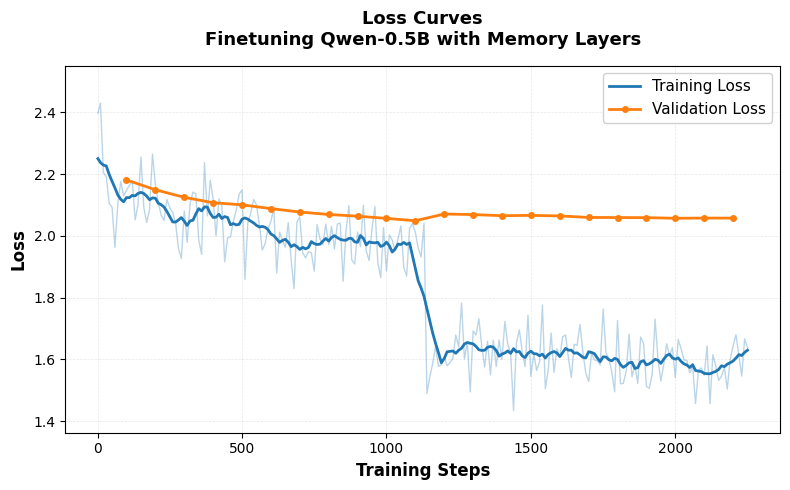

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

# Extract training and evaluation losses
log_history = trainer.state.log_history
train_losses = [(log['step'], log['loss']) for log in log_history if 'loss' in log]
eval_losses = [(log['step'], log['eval_loss']) for log in log_history if 'eval_loss' in log]

# Unpack into separate lists
train_steps, train_loss_values = zip(*train_losses) if train_losses else ([], [])
eval_steps, eval_loss_values = zip(*eval_losses) if eval_losses else ([], [])

# Create figure with appropriate size for papers (IEEE standard: 3.5" or 7" width)
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

# Plot training loss (with optional smoothing for cleaner visualization)
if train_steps:
    ax.plot(train_steps, train_loss_values, alpha=0.3, color='#1f77b4', linewidth=1)

    # Add smoothed line if enough data points
    if len(train_loss_values) > 10:
        window_size = min(11, len(train_loss_values) // 3)
        smoothed_loss = uniform_filter1d(train_loss_values, size=window_size)
        ax.plot(train_steps, smoothed_loss, label='Training Loss',
                color='#1f77b4', linewidth=2)
    else:
        ax.plot(train_steps, train_loss_values, label='Training Loss',
                color='#1f77b4', linewidth=2)

# Plot evaluation loss
if eval_steps:
    ax.plot(eval_steps, eval_loss_values, label='Validation Loss',
            color='#ff7f0e', linewidth=2, marker='o', markersize=4)

# Formatting
ax.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Loss Curves\nFinetuning Qwen-0.5B with Memory Layers',
             fontsize=13, fontweight='bold', pad=15)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

# Set y-axis to start from a reasonable minimum
if train_loss_values or eval_loss_values:
    all_losses = list(train_loss_values) + list(eval_loss_values)
    y_min = min(all_losses) * 0.95
    y_max = max(all_losses) * 1.05
    ax.set_ylim(y_min, y_max)

# Tight layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Optionally save as high-quality figure for paper
# fig.savefig('loss_curve.pdf', dpi=300, bbox_inches='tight')
# fig.savefig('loss_curve.png', dpi=300, bbox_inches='tight')


In [11]:
del model
torch.cuda.empty_cache()

In [ ]:
from safetensors.torch import load_file

device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_dim = 896
layers_to_replace = [6, 12, 18]

# Reload model for testing
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B-Instruct",
    dtype=torch.float16,
).to(device)

# Add memory layers
for idx in layers_to_replace:
    # Initialize and cast to correct device/dtype
    mem_layer = HashingMemory(
        input_dim=hidden_dim, output_dim=hidden_dim, mem_n_keys=128, mem_heads=4,
        mem_knn=16, mem_k_dim=256, mem_v_dim=-1, swilu_projection=True,
        value_fixed_lr=0.001, mem_share_values=False
    )
    # Important: Cast to model's dtype (float16) to avoid "Half and Float" errors
    model.model.layers[idx].mlp = mem_layer.to(device, dtype=model.dtype)

# Load weights
try:
    state_dict = load_file("./qwen_memory_distilled_final/model.safetensors")
    print("Loaded from safetensors")
except:
    state_dict = torch.load("./qwen_memory_distilled_final/pytorch_model.bin", 
                           weights_only=False)

model.load_state_dict(state_dict, strict=False)
print("\n✅ Model loaded successfully!")

# Test generation
def test_model(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Try some prompts
# test_prompts = [
#     "Explain quantum computing in simple terms:",
#     "Write a Python function to sort a list:",
#     "What are the health benefits of exercise?",
# ]

# for prompt in test_prompts:
#     print(f"\n{'='*80}")
#     print(f"Prompt: {prompt}")
#     print(f"{'='*80}")
#     response = test_model(prompt)
#     print(response)

Loaded from safetensors

✅ Model loaded successfully!


In [13]:
print("📊 Evaluating Base Model With Init Memory Values...")
# Create a temporary trainer just for evaluation
base_trainer = Trainer(
    model=model,
    eval_dataset=eval_dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
base_metrics = base_trainer.evaluate()
print(f"Base Model With Init Memory Values Eval Loss: {base_metrics['eval_loss']:.4f}")
print(f"Base Model With Init Memory Values Perplexity: {torch.exp(torch.tensor(base_metrics['eval_loss'])):.4f}")

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


📊 Evaluating Base Model With Init Memory Values...


Base Model With Init Memory Values Eval Loss: 2.0576
Base Model With Init Memory Values Perplexity: 7.8269
